In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import uuid
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from qdrant_client import models, QdrantClient



c:\Users\manuelalberto.romero\Documents\repos\dslabs\dslab-rag-retrieval\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Params

In [3]:
INDEX = "ragquas-minilm-01"
RETRIEVE_K=5
EVAL_K = 3

# Load Data

In [4]:
ds_ragquas = load_dataset("IIC/RagQuAS")
ds_ragquas
# https://huggingface.co/datasets/IIC/RagQuAS

DatasetDict({
    test: Dataset({
        features: ['topic', 'answer', 'question', 'variant', 'context_1', 'context_2', 'context_3', 'context_4', 'context_5', 'link_1', 'link_2', 'link_3', 'link_4', 'link_5', 'text_1', 'text_2', 'text_3', 'text_4', 'text_5'],
        num_rows: 201
    })
})

In [ ]:
ds_ragquas["test"].take(2).to_pandas()

,topic,answer,question,variant,context_1,context_2,context_3,context_4,context_5,link_1,link_2,link_3,link_4,link_5,text_1,text_2,text_3,text_4,text_5
0,reclamaciones,La opción más fácil y eficaz para reclamar una...,¿Cuál es la forma más fácil de reclamar cuando...,question_1,#1. Airhelp\n\nLa empresa Airhelp fue fundada ...,En AirHelp hemos ayudado a más de 16 millones ...,"MYFLYRIGHT, expertos en derechos de los viajer...",,,https://www.businessinsider.es/mejores-paginas...,https://www.airhelp.com/es/retrasos-de-vuelos/,https://myflyright.com/es/servicios/vuelo-retr...,,,5 páginas donde poder reclamar tus vuelos por ...,Conoce las compensaciones cuando se retrasa tu...,Indemnización retraso vuelo\n\nNavegación por ...,,
1,reclamaciones,La opción más fácil y eficaz para reclamar una...,hola mi vuelo a Alemania se ha retrasado mucho...,question_2,#1. Airhelp\n\nLa empresa Airhelp fue fundada ...,En AirHelp hemos ayudado a más de 16 millones ...,"MYFLYRIGHT, expertos en derechos de los viajer...",,,https://www.businessinsider.es/mejores-paginas...,https://www.airhelp.com/es/retrasos-de-vuelos/,https://myflyright.com/es/servicios/vuelo-retr...,,,5 páginas donde poder reclamar tus vuelos por ...,Conoce las compensaciones cuando se retrasa tu...,Indemnización retraso vuelo\n\nNavegación por ...,,
2,reclamaciones,La opción más fácil y eficaz para reclamar una...,cómo puedo poner una reclamación para que me d...,question_3,#1. Airhelp\n\nLa empresa Airhelp fue fundada ...,En AirHelp hemos ayudado a más de 16 millones ...,"MYFLYRIGHT, expertos en derechos de los viajer...",,,https://www.businessinsider.es/mejores-paginas...,https://www.airhelp.com/es/retrasos-de-vuelos/,https://myflyright.com/es/servicios/vuelo-retr...,,,5 páginas donde poder reclamar tus vuelos por ...,Conoce las compensaciones cuando se retrasa tu...,Indemnización retraso vuelo\n\nNavegación por ...,,
3,reclamaciones,La opción más fácil y eficaz para reclamar una...,forma eficaz de reclamar a aerolinea por retra...,question_4,#1. Airhelp\n\nLa empresa Airhelp fue fundada ...,En AirHelp hemos ayudado a más de 16 millones ...,"MYFLYRIGHT, expertos en derechos de los viajer...",,,https://www.businessinsider.es/mejores-paginas...,https://www.airhelp.com/es/retrasos-de-vuelos/,https://myflyright.com/es/servicios/vuelo-retr...,,,5 páginas donde poder reclamar tus vuelos por ...,Conoce las compensaciones cuando se retrasa tu...,Indemnización retraso vuelo\n\nNavegación por ...,,
4,reclamaciones,La opción más fácil y eficaz para reclamar una...,hay alguna forma de reclamar por retrasos en v...,question_5,#1. Airhelp\n\nLa empresa Airhelp fue fundada ...,En AirHelp hemos ayudado a más de 16 millones ...,"MYFLYRIGHT, expertos en derechos de los viajer...",,,https://www.businessinsider.es/mejores-paginas...,https://www.airhelp.com/es/retrasos-de-vuelos/,https://myflyright.com/es/servicios/vuelo-retr...,,,5 páginas donde poder reclamar tus vuelos por ...,Conoce las compensaciones cuando se retrasa tu...,Indemnización retraso vuelo\n\nNavegación por ...,,
5,hobbies,Si estás interesado en buscar setas en la Sier...,Quiero ir a buscar setas por la Sierra de Madr...,question_1,1. Siempre hay que respetar el entorno natural...,No recolectar ni aceptar setas que no conozcam...,Las setas se recogen en cestas y nunca en bols...,Setas en Alameda del valle.\n\nEste pequeño ri...,Valle del Paular\n\nConocido también con el no...,https://www.sierranorte.com/consejos-coger-set...,https://www.comunidad.madrid/servicios/salud/s...,https://madridsecreto.co/buscar-setas-madrid/#...,https://lacasadelassetas.com/blog/buscar-setas...,https://www.larazon.es/madrid/mejores-lugares-...,10 Consejos Básicos para coger Setas en la Sie...,Recoger y consumir setas silvestres\n\nLa iden...,Los mejores lugares para buscar setas en la Co...,Escaparse de Madrid para buscar setas\nBuscar ...,Los mejores lugares para buscar setas en Madri...
6,hobbies,Si estás interesado en buscar setas en la Sier...,"hola, v

# Explore Data

In [6]:
df_ragquas = ds_ragquas["test"].to_pandas()

<Axes: title={'center': 'Topic Frequency'}, ylabel='topic'>

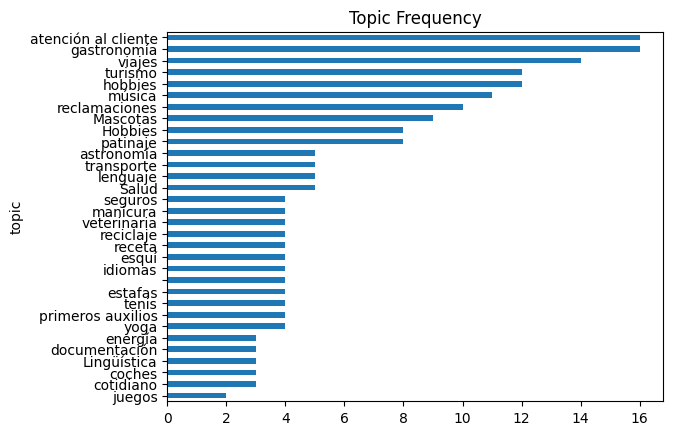

In [7]:
df_ragquas["topic"].value_counts().sort_values(ascending=True).plot.barh(
    title="Topic Frequency"
)

In [8]:
ans_rep = df_ragquas["answer"].value_counts()

ans_rep.iloc[0]  # se repite N veces, que son diferenciadas por variant (y por question, que presenta pequeñas variaciones)

np.int64(5)

In [9]:
set(ans_rep.values)  # posibilidades de repetición de una respuesta

{np.int64(2), np.int64(3), np.int64(4), np.int64(5)}

In [10]:
df_variant_freq = df_ragquas["variant"].value_counts()
df_variant_freq


variant
question_1    50
question_2    50
question_3    49
question_4    41
question_5    11
Name: count, dtype: int64

In [11]:
df_ragquas[["context_1", "context_2", "context_3", "context_4",	"context_5"]].isna().sum()
# NANs como string vacio

context_1    0
context_2    0
context_3    0
context_4    0
context_5    0
dtype: int64

In [12]:
df_ragquas[["context_1", "context_2", "context_3", "context_4",	"context_5"]].apply(len).describe()
# cada celda tiene espacios vacios a la derecha

count      5.0
mean     201.0
std        0.0
min      201.0
25%      201.0
50%      201.0
75%      201.0
max      201.0
dtype: float64

# Prepare Data

In [13]:
# Como las columnas text_ están a lo ancho,
# hay que pivotarlas para colocaras a lo largo y codificar cada valor
# pero antes, como hay respuestas que hacen referencia al mismo texto fuente
# hay que quedarse solo con uno de los valores de variant

df_docs = pd.wide_to_long(
    (df_ragquas
     .reset_index()  # crea columna index
     .loc[df_ragquas['variant'] == "question_1"]
     ),
    stubnames=["context_", "text_", "link_"],  # columas a pivotar, solo prefijo
    i=["index", "topic", "variant", "question", "answer"],  # index en el df resultante
    j="j",  # numerador de _1 a _5  (numero de sufijos),
    suffix="\d+"  # forma del sufijo: numero
)


print(f"Raw shape: {df_docs.shape}")

# Como hay text con "", hay que eliminarlos para no indexar algo vacio
df_docs["text_"] = (df_docs["text_"]
           .apply(str.rstrip)
           .replace({"": pd.NA})
           )

df_docs = (df_docs
           .dropna()
           .reset_index()
           )

# agregar un id a cada text_ para poder hacer la evaluacion posteiormente
df_docs['uuid'] = [str(uuid.uuid4()) for _ in range(len(df_docs))]


df_docs.info()

Raw shape: (250, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     183 non-null    int64 
 1   topic     183 non-null    object
 2   variant   183 non-null    object
 3   question  183 non-null    object
 4   answer    183 non-null    object
 5   j         183 non-null    int64 
 6   context_  183 non-null    object
 7   text_     183 non-null    object
 8   link_     183 non-null    object
 9   uuid      183 non-null    object
dtypes: int64(2), object(8)
memory usage: 14.4+ KB


In [14]:
df_docs.iloc[:2]

,index,topic,variant,question,answer,j,context_,text_,link_,uuid
0,0,reclamaciones,question_1,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,1,#1. Airhelp\n\nLa empresa Airhelp fue fundada ...,5 páginas donde poder reclamar tus vuelos por ...,https://www.businessinsider.es/mejores-paginas...,d4d3062b-8d20-490a-ad99-3531c7c294dc
1,0,reclamaciones,question_1,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,2,En AirHelp hemos ayudado a más de 16 millones ...,Conoce las compensaciones cuando se retrasa tu...,https://www.airhelp.com/es/retrasos-de-vuelos/,f0852dcb-d2b6-4f1d-a128-6def7b4e3df2


# Index

In [15]:
# Embedding model

encoder = SentenceTransformer("all-MiniLM-L6-v2")

lst_embeddings = encoder.encode(df_docs['text_'].tolist())

print(f"{len(lst_embeddings)}")
print(f"{len(lst_embeddings[0])}")  # embeddings dimension


183
384


Qdrant acepta como entrada una estructura de datos denominada Point que tiene esta forma:

```python
{
    "id": 129,
    "vector": [0.1, 0.2, 0.3, 0.4],
    "payload": {"color": "red"},
}
```

[Points](https://qdrant.tech/documentation/concepts/points/)

In [ ]:
# La VBD Qdrant acepta una lista de 

lst_qdrant_pts = []

for idx, row in df_docs.iterrows():
    qdrant_point = models.PointStruct(
        id=row['uuid'],  # uuid aleatorio
        payload={
            "text": row['text_'],
            "topic": row['topic'],
            "answer_idx": row['index'],  # index antes de filtrar las variant == question1
            "text_j": row['j'],
            "idx":  row['index'],  
        },
        vector=lst_embeddings[idx]  # se puede buscar directamente en la lista por indice del DF pivotado
    )
    lst_qdrant_pts.append(qdrant_point)

    len(lst_qdrant_pts) == len(df_docs)

In [17]:
# Instanciate client
# Si está levantada localmente: QdrantClient("http://localhost:6333")
# Su se usa la versión cloud, introducir la url

client = QdrantClient(":memory:")  # en memoria

client.create_collection(
    collection_name=INDEX,
    vectors_config=models.VectorParams(
        size=encoder.get_sentence_embedding_dimension(),
        distance=models.Distance.COSINE,
    ),
)

client.upsert(
    collection_name=INDEX,
    points=lst_qdrant_pts
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [18]:
# query by id
_id = lst_qdrant_pts[0].id
print(f"{_id=}")

client.retrieve(
    collection_name=INDEX,
    ids=[_id]
)



_id='d4d3062b-8d20-490a-ad99-3531c7c294dc'


[Record(id='d4d3062b-8d20-490a-ad99-3531c7c294dc', payload={'text': '5 páginas donde poder reclamar tus vuelos por retraso o cancelación de manera gratuita\nIrina Pérez\n\n    En muchas ocasiones no se realiza la reclamación de un vuelo por retraso o cancelación, porque se desconocen los derechos como pasajeros y la manera de realizar el trámite. \n    Por ello, aquí van 5 reclamadores online que te ayudarán a conseguir una indemnización por tu vuelo, sin que tengas que desplazarte ni hacer papeleos.\n    Descubre más historias en Business Insider España.\n\nVolar es siempre sinónimo de nervios, normalmente ir al aeropuerto con tiempo, las colas en facturación, o cualquier imprevisto, hacen que a veces viajar sea una odisea. En el peor de los casos tu vuelo puede sufrir retrasos e incluso cancelarse. Pero, ¿sabías que tienes derecho a una compensación económica cuando esto ocurre?\n\nEn muchas ocasiones reclamar, es algo que se deja pasar porque es tedioso, y requiere hacer papeleo, de

In [19]:
# query by vector (retrieval)

_q_text = df_docs.iloc[0]["question"]
_q = encoder.encode(_q_text)
print(type(_q))

resp = client.query_points(
    collection_name=INDEX,
    query=_q,
    limit=10
)


print(f"Question: {_q_text}")
for point in resp.points:
    doc_retrieved = point.payload['text']
    print(f"{point.id=}")
    print(f"{point.score=}")
    print(f"Doc: {doc_retrieved[:500]}...")
    print(f"idx: {point.payload['idx']}, j: {point.payload['text_j']}")
    print("-"*30)

<class 'numpy.ndarray'>
Question: ¿Cuál es la forma más fácil de reclamar cuando un vuelo que sale de España se ha retrasado?
point.id='097b6ccb-21c0-4a4e-bb36-a850406d3221'
point.score=0.6237602516683067
Doc: ¿Qué hacer con una hoja de reclamaciones después de solicitarla en la tienda?
Óscar F. Civieta

    En ocasiones, directamente, no se pide porque pensamos que no servirá de nada. En otras sí se reclama, pero luego no sabemos qué hacer con la hoja de reclamaciones.
    Te explicamos, paso a paso, dónde y cómo has de presentar esta queja si no estás conforme con un producto o servicio recibido.
    Descubre más historias en Business Insider España.

"No va a servir de nada, prefiero pasar del tema...
idx: 144, j: 1
------------------------------
point.id='d4d3062b-8d20-490a-ad99-3531c7c294dc'
point.score=0.5772483966936661
Doc: 5 páginas donde poder reclamar tus vuelos por retraso o cancelación de manera gratuita
Irina Pérez

    En muchas ocasiones no se realiza la reclamación de 

In [20]:
# check scores

se_scores = pd.Series(data=[point.score for point in resp.points])
se_scores.index.name = "rank"
se_scores.name = "scores"
se_scores

rank
0    0.623760
1    0.577248
2    0.573829
3    0.562039
4    0.519066
5    0.514474
6    0.514474
7    0.507553
8    0.495966
9    0.495966
Name: scores, dtype: float64

# Evaluation

**Discounted Cumulative Gain**
$$DCG@k = \sum_{i=1}^{k} \frac{2^{rel_i} - 1}{\log_2(i+1)}$$

**Ideal Discounted Cumulative Gain**

$$IDCG@k = \sum_{i=1}^{k} \frac{2^{rel_i^\ast} - 1}{\log_2(i+1)}$$

**Normalized DCG**
$$NDCG@k = \frac{DCG@k}{IDCG@k}$$

[sklearn ndcg_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html)

## Get y_trues


In [21]:
df_ytrues = (df_docs[["index", "question", "answer", "j", "text_", "uuid"]]
             .rename(columns={"j": "y_true"})
             )
df_ytrues.head()

,index,question,answer,y_true,text_,uuid
0,0,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,1,5 páginas donde poder reclamar tus vuelos por ...,d4d3062b-8d20-490a-ad99-3531c7c294dc
1,0,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,2,Conoce las compensaciones cuando se retrasa tu...,f0852dcb-d2b6-4f1d-a128-6def7b4e3df2
2,0,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,3,Indemnización retraso vuelo\n\nNavegación por ...,05961572-1998-4e48-918c-9d3825a22fa2
3,5,Quiero ir a buscar setas por la Sierra de Madr...,Si estás interesado en buscar setas en la Sier...,1,10 Consejos Básicos para coger Setas en la Sie...,67ecb7d6-4d2c-4291-845b-0af63122eaf1
4,5,Quiero ir a buscar setas por la Sierra de Madr...,Si estás interesado en buscar setas en la Sier...,2,Recoger y consumir setas silvestres\n\nLa iden...,c1778fb1-a06d-4cb1-af43-4f29143612c3


## Get y_preds

In [22]:
lst_retrivals = []
df_ans = df_docs.loc[df_docs['j'] == 1, ["index", "question"]]  # questions are repeated

for idx, row in df_ans.iterrows():
    _q_text = row["question"]
    _q = encoder.encode(_q_text)
    _resp = client.query_points(
        collection_name=INDEX,
        query=_q,
        limit=RETRIEVE_K
    )
    for rank, point in enumerate(_resp.points):
        lst_retrivals.append(
            {
                "index": row["index"],
                "uuid": point.id,
                "y_pred": rank +1

            }
        )

df_yhats =  pd.DataFrame(lst_retrivals)
df_yhats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   250 non-null    int64 
 1   uuid    250 non-null    object
 2   y_pred  250 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 6.0+ KB


## Format the Dataset 

* Each row is a question
* `y_true` a list where each element represent a given document (`uuid`) actual rank
* `y_pred` a list where each element represent the same document on `y_true` predicted rank
* Both list must have the same number of elements `EVAL_K`

| index | y_true     | y_pred     |
|-------|------------|------------|
| 0     | [1, 2, 3]  | [2, 3, 5]  |
| 5     | [3, 4, 5]  | [2, 1, 3]  |
| 12    | [1, 2, 3]  | [2, 5, 4]  |


In [23]:
df_ytrues.head(2)

,index,question,answer,y_true,text_,uuid
0,0,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,1,5 páginas donde poder reclamar tus vuelos por ...,d4d3062b-8d20-490a-ad99-3531c7c294dc
1,0,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,2,Conoce las compensaciones cuando se retrasa tu...,f0852dcb-d2b6-4f1d-a128-6def7b4e3df2


In [24]:
df_yhats.head(2)

,index,uuid,y_pred
0,0,097b6ccb-21c0-4a4e-bb36-a850406d3221,1
1,0,d4d3062b-8d20-490a-ad99-3531c7c294dc,2


In [25]:
df_eval = df_ytrues.merge(df_yhats, how="left", on=['index', 'uuid'])  # los elementos de las listas deben ser los mismos documentos
df_eval.head(5)


,index,question,answer,y_true,text_,uuid,y_pred
0,0,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,1,5 páginas donde poder reclamar tus vuelos por ...,d4d3062b-8d20-490a-ad99-3531c7c294dc,2.0
1,0,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,2,Conoce las compensaciones cuando se retrasa tu...,f0852dcb-d2b6-4f1d-a128-6def7b4e3df2,3.0
2,0,¿Cuál es la forma más fácil de reclamar cuando...,La opción más fácil y eficaz para reclamar una...,3,Indemnización retraso vuelo\n\nNavegación por ...,05961572-1998-4e48-918c-9d3825a22fa2,5.0
3,5,Quiero ir a buscar setas por la Sierra de Madr...,Si estás interesado en buscar setas en la Sier...,1,10 Consejos Básicos para coger Setas en la Sie...,67ecb7d6-4d2c-4291-845b-0af63122eaf1,NaN
4,5,Quiero ir a buscar setas por la Sierra de Madr...,Si estás interesado en buscar setas en la Sier...,2,Recoger y consumir setas silvestres\n\nLa iden...,c1778fb1-a06d-4cb1-af43-4f29143612c3,NaN


In [26]:
pd.crosstab(
    df_eval["y_true"],
    df_eval["y_pred"],
    dropna=False  # no recuperado

)

y_pred,1.0,2.0,3.0,4.0,5.0,NaN
y_true,,,,,,
1,9,15,4,3,6,13
2,10,10,9,4,4,12
3,7,7,13,3,3,9
4,9,4,2,6,0,6
5,4,3,2,2,2,2


In [27]:
import numpy as np
from sklearn.metrics import ndcg_score

df_eval_ndcg = df_eval[["uuid", "index", "y_true", "y_pred"]].fillna(99)   # si no se recupera, se le da un número muy grande
df_eval_ndcg['y_pred'] = df_eval_ndcg['y_pred'].astype(int)  # casteado a float por los nan

# Colapsar todas las y_trues e y_pred de una question en una sola fila,
# de tal forma que las celdas sean listas, pero del un tamaño `EVAL_K`
df_eval_ndcg_agg = (df_eval_ndcg
                    .groupby("index")[["y_true", "y_pred"]]
                    .agg(lambda grp: list(grp[:EVAL_K]))
                    )

# Eliminar las filas que tengan un rank real menor al esperado
df_eval_ndcg_agg['len_y_trues'] = df_eval_ndcg_agg['y_true'].apply(len)
df_eval_ndcg_agg = df_eval_ndcg_agg.loc[
    df_eval_ndcg_agg['len_y_trues'] >= EVAL_K
]


df_eval_ndcg_agg.head()

,y_true,y_pred,len_y_trues
index,,,
0,"[1, 2, 3]","[2, 3, 5]",3
5,"[1, 2, 3]","[99, 99, 2]",3
8,"[1, 2, 3]","[99, 99, 99]",3
12,"[1, 2, 3]","[2, 5, 4]",3
16,"[1, 2, 3]","[5, 4, 2]",3


## Compute nDCG score

In [28]:
y_trues = np.array(df_eval_ndcg_agg["y_true"].tolist())
y_pred = np.array(df_eval_ndcg_agg["y_pred"].tolist())

ndcg_score(
    y_trues,
    y_pred,
    k=RETRIEVE_K)

0.8805040813616107